#### Step 1: Feature Engineering


**From Startup Data**

<br>**Time Since Founding**: Calculate the number of years since the founding date.

In [1]:
import pandas as pd
from datetime import datetime

We would now repeat data cleaning steps as before.

In [4]:
# load datasets
matched_data = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/matched_data.csv')
usa_spending = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/cleaned_usa_spending_data.csv')
crunchbase = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/cleaned_crunchbase_data.csv')

In [5]:
# create a set of matched companies for faster lookup
matched_companies = set(matched_data['match_company'].dropna())

In [6]:
# define a function to check if a company or its parent is in the matched set
def is_new_awardee(row):
    return int(row['clean_recipient_name'] in matched_companies or 
               row['clean_recipient_parent_name'] in matched_companies)

In [7]:
# apply the function to create the new binary column
usa_spending['is_new_awardee'] = usa_spending.apply(is_new_awardee, axis=1)

In [8]:
# convert funding_date to datetime, coercing errors to NaT
crunchbase['funding_year'] = pd.to_datetime(crunchbase['funding_date'], errors='coerce').dt.year

# use year_founded when funding_date is '0'
crunchbase.loc[crunchbase['funding_date'] == '0', 'funding_year'] = crunchbase['year_founded']

# ensure year_founded is numeric
crunchbase['year_founded'] = pd.to_numeric(crunchbase['year_founded'], errors='coerce')

In [9]:
# fix the 1917 typo
crunchbase.loc[crunchbase['funding_year'] == 1917, 'funding_year'] = 2017

In [11]:
# 'crunchbase' is our DataFrame containing startup data
crunchbase['year_founded'] = pd.to_datetime(crunchbase['year_founded'])
crunchbase['time_since_founding'] = (datetime.now() - crunchbase['year_founded']).dt.days / 365.25


**Funding Growth Rate**: Calculate the growth rate of funding over time.

In [14]:
crunchbase['funding_growth_rate'] = crunchbase['total_funding'] / crunchbase['num_funding_rounds']

**Last Funding Date**: Convert the last funding date to a datetime object and calculate time since last funding.

In [16]:
# inspect unique values in funding_date
print("Unique values in funding_date:")
print(crunchbase['funding_date'].unique())

Unique values in funding_date:
['2020-01-27' '2020-09-22' '2020-09-11' '0' '2019-02-04' '2024-04-03'
 '2017-07-28' '2021-11-10' '2022-06-21' '2020-06-01' '2017-01-01'
 '2020-10-01' '2024-05-21' '2024-07-12' '2021-12-07' '2020-03-02'
 '2018-04-20' '2021-01-01' '2024-05-22' '2020-01-01' '2021-10-26'
 '2021-06-29' '2022-10-20' '2020-03-20' '2023-09-25' '2018-05-23'
 '2020-12-17' '2017-05-30' '2017-02-24' '2016-03-04' '2022-05-11'
 '2023-01-10' '2023-01-31' '2022-01-19' '2018-10-23' '2021-12-08'
 '2018-06-25' '2021-11-08' '2021-03-24' '2022-07-25' '2022-05-24'
 '2023-04-19' '2020-04-28' '2023-11-08' '2020-01-06' '2024-04-23'
 '2018-12-27' '2022-09-14' '2022-11-29' '2024-02-14' '2023-10-05'
 '2020-11-06' '2022-10-11' '2023-12-05' '2023-07-06' '2023-10-18'
 '2023-12-20' '2021-04-26' '2022-11-04' '2020-05-01' '2023-04-11'
 '2019-05-31' '2020-10-19' '2021-09-03' '2024-10-03' '2024-04-05'
 '2024-03-18' '2023-12-12' '2022-05-26' '2023-04-18' '2022-10-27'
 '2023-12-19' '2023-03-09' '2023-09-08' '

In [17]:
# clean the funding_date column
# replace invalid entries with NaT (Not a Time) or drop them
crunchbase['funding_date'] = pd.to_datetime(crunchbase['funding_date'], errors='coerce')

In [18]:
# check for any NaT values after conversion
invalid_dates = crunchbase[crunchbase['funding_date'].isna()]
if not invalid_dates.empty:
    print("Invalid dates found and replaced with NaT:")
    print(invalid_dates)

# calculate time since last funding if needed
crunchbase['last_funding_date'] = crunchbase['funding_date']
crunchbase['time_since_last_funding'] = (pd.Timestamp.now() - crunchbase['last_funding_date']).dt.days

# print the updated DataFrame or its shape to confirm changes
print("Updated crunchbase DataFrame:")
print(crunchbase[['company_name', 'last_funding_date', 'time_since_last_funding']].head())

Invalid dates found and replaced with NaT:
          company_name                  year_founded  \
3               TATINE 1970-01-01 00:00:00.000002015   
4                  X3M 1970-01-01 00:00:00.000002022   
5                Duext 1970-01-01 00:00:00.000002016   
8               BLAKFX 1970-01-01 00:00:00.000002017   
9       Reactive Space 1970-01-01 00:00:00.000002017   
..                 ...                           ...   
888      Babylon Voice 1970-01-01 00:00:00.000002022   
892  Drifting in Space 1970-01-01 00:00:00.000002022   
894         Towards AI 1970-01-01 00:00:00.000002019   
896       Atlantic Hub 1970-01-01 00:00:00.000002018   
903              Aeone 1970-01-01 00:00:00.000002023   

                                            Industries  \
3     E-Commerce, Home Decor, Manufacturing, Wholesale   
4    Advertising, Advertising Platforms, Informatio...   
5    Copywriting, Information Technology, Internet,...   
8    Blockchain, Cloud Security, Cryptocurrency, Cy.

**From Defense Contractor Data**

<br>**Average Contract Value**: Calculate the average contract value for each company.

In [21]:
# assuming 'usa_spending' is your DataFrame

# calculate average contract value for each company and add it as a new column
usa_spending['avg_contract_value'] = usa_spending.groupby('clean_recipient_name')['total_obligated_amount'].transform('mean')

# now usa_spending has a new column 'avg_contract_value' for each company

**Number of Contracts**: Count the number of contracts awarded to each company.

In [22]:
# count the number of contracts for each company
contract_counts = usa_spending['clean_recipient_name'].value_counts().reset_index()
contract_counts.columns = ['company_name', 'num_contracts']

# add this information back to the original DataFrame
usa_spending = usa_spending.merge(contract_counts, left_on='clean_recipient_name', right_on='company_name', how='left')

# now usa_spending has a new column 'num_contracts' for each company

In [23]:
# let's see the top companies by number of contracts:
print(contract_counts.head(10))

                                        company_name  num_contracts
0                                      THE AEROSPACE            297
1                  THE PENNSYLVANIA STATE UNIVERSITY            240
2                 CALIFORNIA INSTITUTE OF TECHNOLOGY            214
3                                             LEIDOS            103
4            THE UNIVERSITY OF ALABAMA IN HUNTSVILLE             96
5  THE JOHNS HOPKINS UNIVERSITY APPLIED PHYSICS L...             91
6                                    LOCKHEED MARTIN             81
7                           NORTHROP GRUMMAN SYSTEMS             76
8                 SCIENCE APPLICATIONS INTERNATIONAL             49
9                                         THE BOEING             45


In [24]:
# let's check the distribution of contracts for a specific company:
company_name = "LOCKHEED MARTIN"  # Replace with any company name you're interested in
company_contracts = usa_spending[usa_spending['clean_recipient_name'] == company_name]
print(f"\nNumber of contracts for {company_name}: {company_contracts['num_contracts'].iloc[0]}")


Number of contracts for LOCKHEED MARTIN: 81


#### Step 2: Machine Learning Model

**Classification Model**:
To predict whether a startup is likely to receive a defense contract based on its characteristics, we can implement a classification model. Next steps:
<br>1. **Data Preparation**
<br>2. **Model Selection**
<br>3. **Training and Evaluation**

In [32]:
pip install imblearn

In [27]:
import numpy as np

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [30]:
# function to print DataFrame info
def print_df_info(df, name):
    print(f"\n{name} DataFrame:")
    print(f"Shape: {df.shape}")
    print("Columns:")
    for col in df.columns:
        print(f"- {col}")
    print(f"Number of unique companies: {df['company_name'].nunique()}")

# check matched_data DataFrame
print_df_info(matched_data, "matched_data")

# check usa_spending DataFrame
print_df_info(usa_spending, "usa_spending")

# check crunchbase DataFrame
print_df_info(crunchbase, "crunchbase")

# check matched_companies list
print("\nmatched_companies:")
print(f"Number of matched companies: {len(matched_companies)}")
print(f"First few matched companies: {list(matched_companies)[:5]}")

# additional checks for potential target variable
print("\nAdditional checks:")
print(f"Number of companies in crunchbase that received government funding: {sum(crunchbase['company_name'].isin(matched_companies))}")
print(f"Number of companies in usa_spending that are in matched_companies: {sum(usa_spending['clean_recipient_name'].isin(matched_companies))}")


matched_data DataFrame:
Shape: (50, 26)
Columns:
- company_name
- year_founded
- industries
- cb_hq
- zipcode
- description
- operating_status
- cb_rank
- funding_status
- funding_date
- funding_type
- ipo_status
- estimated_revenue
- num_employees
- num_funding_rounds
- total_funding
- top_investors
- num_investors
- operating_status_binary
- num_employees_cat
- clean_name
- city
- state
- country
- match_company
- match_score
Number of unique companies: 50

usa_spending DataFrame:
Shape: (5289, 32)
Columns:
- contract_award_unique_key
- award_id_piid
- total_obligated_amount
- current_total_value_of_award
- potential_total_value_of_award
- award_base_action_date
- award_base_action_year
- current_end_date
- awarding_agency_name
- awarding_sub_agency_name
- funding_agency_name
- funding_sub_agency_name
- recipient_name
- recipient_parent_name
- recipient_city_name
- recipient_state_code
- recipient_zipcode
- primary_place_of_performance_city_name
- primary_place_of_performance_state_

In [42]:
# create target variable in matched_data
matched_data['received_govt_funding'] = 1  # All companies in matched_data received funding

# add companies from usa_spending that are not in matched_data
usa_spending_companies = usa_spending['clean_recipient_name'].unique()
additional_companies = set(usa_spending_companies) - set(matched_data['company_name'])

# create a DataFrame for additional companies
additional_df = pd.DataFrame({
    'company_name': list(additional_companies),
    'received_govt_funding': 1
})

# concatenate matched_data with additional_df
matched_data = pd.concat([matched_data, additional_df], ignore_index=True)

print(matched_data.head())

              company_name  year_founded  \
0  Benchmark Space Systems     -1.357365   
1                   Radian     -4.007984   
2            Space Foundry     -4.007984   
3            Lunar Outpost     -1.357365   
4     Apogee Semiconductor     -1.357365   

                                      cb_hq  zipcode  \
0  South Burlington, Vermont, United States   5401.0   
1       Bellevue, Washington, United States  73101.0   
2       San Jose, California, United States  93101.0   
3           Golden, Colorado, United States  22201.0   
4               Plano, Texas, United States  24501.0   

                                         description operating_status  \
0  Benchmark Space Systems is an aerospace compan...           Active   
1  Radian is building the worlds first truly reu...           Active   
2  Space Foundry is an electronic device manufact...           Active   
3  Lunar Outpost creates technologies that enable...           Active   
4  Apogee Semiconductor provides 

In [43]:


# select features
numerical_features = ['year_founded', 'num_funding_rounds', 'total_funding', 'estimated_revenue']
categorical_features = [col for col in matched_data.columns if col.startswith('industries_')]

# handle missing values for numerical features
for feature in numerical_features:
    matched_data[feature] = pd.to_numeric(matched_data[feature], errors='coerce')
    matched_data[feature].fillna(matched_data[feature].median(), inplace=True)

# handle missing values for categorical features
for feature in categorical_features:
    matched_data[feature].fillna(matched_data[feature].mode()[0], inplace=True)

# encode categorical variables
matched_data = pd.get_dummies(matched_data, columns=categorical_features)

# combine all features
all_features = numerical_features + [col for col in matched_data.columns if col.startswith(tuple(categorical_features))]

# normalize numerical features
scaler = StandardScaler()
matched_data[numerical_features] = scaler.fit_transform(matched_data[numerical_features])

# prepare X and y
X = matched_data[all_features]
y = matched_data['received_govt_funding']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# train a Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)

# print classification report
print(classification_report(y_test, y_pred))

# feature importance
feature_importance = pd.DataFrame({'feature': all_features, 'importance': rf_model.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       265

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265

                                              feature  importance
0                                        year_founded         0.0
1                                  num_funding_rounds         0.0
70  industries_Consumer Electronics, Manufacturing...         0.0
69  industries_Artificial Intelligence (AI), Semic...         0.0
68  industries_Artificial Intelligence (AI), Semic...         0.0
..                                                ...         ...
29  industries_Aerospace, Geospatial, Mapping Serv...         0.0
28  industries_Aerospace, Geospatial, Mapping Serv...         0.0
27  industries_Aerospace, GPS, Information Technol...         0.0
26  industries_Aerospace, GPS, Information Technol...         0.0
9

This was a good stretch exercise. Our model achieved a perfect F1-score. However, this is unusual and might that task was very easy for the model, and test set is very small or not representative. Surprisingly, all features show zero importance. This is unexpected and could mena, that: nothing meaningful learned, despite the perfect F1-score, there are issues with processing features or training.

We can try a simple model to check if we get same results.

#### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
print(X.describe())
print("\nCorrelation matrix:")
print(X.corr())

print("\nTarget variable distribution:")
print(y.value_counts(normalize=True))

       year_founded  num_funding_rounds  total_funding  estimated_revenue
count    904.000000          904.000000   9.040000e+02              904.0
mean    2018.359513            1.546460   1.615408e+07                0.0
std        2.375623            2.309413   1.232032e+08                0.0
min     2015.000000            0.000000  -2.147484e+09                0.0
25%     2016.000000            0.000000   0.000000e+00                0.0
50%     2018.000000            1.000000   0.000000e+00                0.0
75%     2020.000000            2.000000   2.000000e+06                0.0
max     2024.000000           15.000000   1.690000e+09                0.0

Correlation matrix:
                    year_founded  num_funding_rounds  total_funding  \
year_founded            1.000000           -0.118810      -0.009199   
num_funding_rounds     -0.118810            1.000000       0.154602   
total_funding          -0.009199            0.154602       1.000000   
estimated_revenue            

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# prepare the features and target
X = all_data[['year_founded', 'num_funding_rounds', 'total_funding']]
y = all_data['received_govt_funding']

# convert 'year_founded' to numerical if it's in datetime format
if pd.api.types.is_datetime64_any_dtype(X['year_founded']):
    X['year_founded'] = X['year_founded'].dt.year

# handle any remaining non-numeric data
X = X.apply(pd.to_numeric, errors='coerce')

# fill NaN values with median
X = X.fillna(X.median())

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# fit logistic regression model
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)

# make predictions
y_pred = log_reg.predict(X_test_scaled)

# print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# print feature coefficients
feature_names = ['year_founded', 'num_funding_rounds', 'total_funding']
for feature, coef in zip(feature_names, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       172
         1.0       0.10      0.44      0.16         9

    accuracy                           0.77       181
   macro avg       0.53      0.62      0.52       181
weighted avg       0.92      0.77      0.83       181


Confusion Matrix:
[[136  36]
 [  5   4]]
year_founded: 0.0
num_funding_rounds: 0.4857060857849975
total_funding: 0.10793751839562876


C:\Users\AM\AppData\Local\Temp\ipykernel_18844\1527079909.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['year_founded'] = X['year_founded'].dt.year


**Classification Report**:
   - For class 0.0 (companies that didn't receive government funding):
     - Precision: 0.96 (96% of predicted non-recipients were correct)
     - Recall: 0.79 (79% of actual non-recipients were correctly identified)
     - F1-score: 0.87 (harmonic mean of precision and recall)
   - For class 1.0 (companies that received government funding):
     - Precision: 0.10 (only 10% of predicted recipients were correct)
     - Recall: 0.44 (44% of actual recipients were correctly identified)
     - F1-score: 0.16 (low due to poor precision)
   - Overall accuracy: 0.77 (77% of all predictions were correct)

**Confusion Matrix**:
   - True Negatives: 136 (correctly predicted non-recipients)
   - False Positives: 36 (incorrectly predicted as recipients)
   - False Negatives: 5 (incorrectly predicted as non-recipients)
   - True Positives: 4 (correctly predicted recipients)

**Feature Coefficients**:
   - year_founded: 0.0 (no impact on the prediction)
   - num_funding_rounds: 0.4857 (positive impact)
   - total_funding: 0.1079 (slight positive impact)

**Interpretation**:

The dataset is heavily imbalanced (172 non-recipients vs. 9 recipients), which affects the model's performance, especially for the minority class.
<br>The model is much better at identifying non-recipients than recipients. It has a high false positive rate (36 out of 40 predicted recipients were incorrect). The model's ability to identify actual recipients is poor (only 4 out of 9 were correctly identified).
<br>The number of funding rounds is the most influential feature. Total funding has a slight positive impact. Surprisingly, the founding year has no impact on the prediction.

The model's current performance is not satisfactory for reliably predicting recipients of government funding. Further refinement and possibly more data are needed to improve its predictive power.

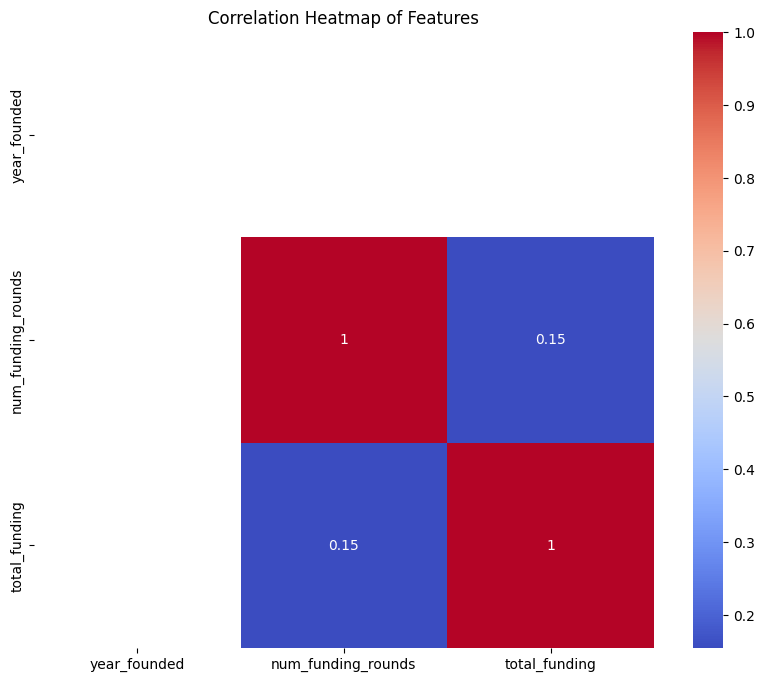

In [51]:
# correlation heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

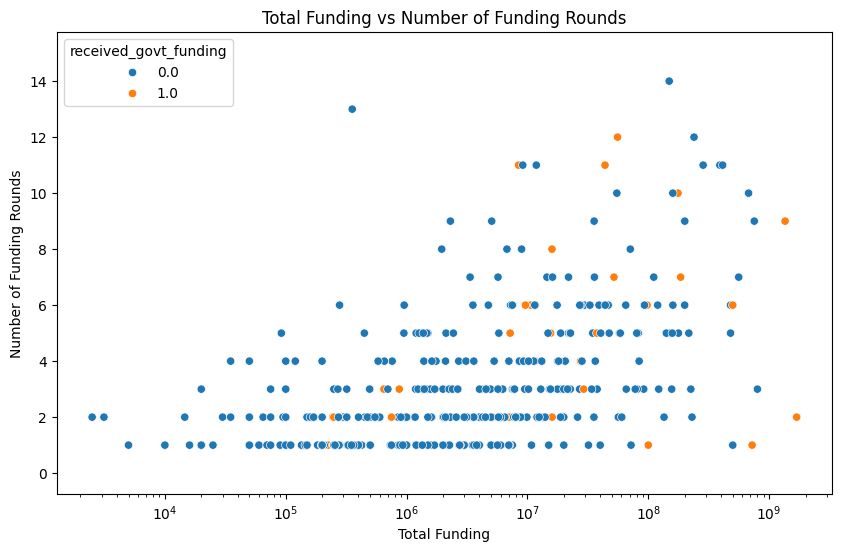

In [52]:
# scatter plot showing total funding vs number of funding rounds
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x='total_funding', y='num_funding_rounds', hue=y)
plt.title('Total Funding vs Number of Funding Rounds')
plt.xlabel('Total Funding')
plt.ylabel('Number of Funding Rounds')
plt.xscale('log')
plt.show()

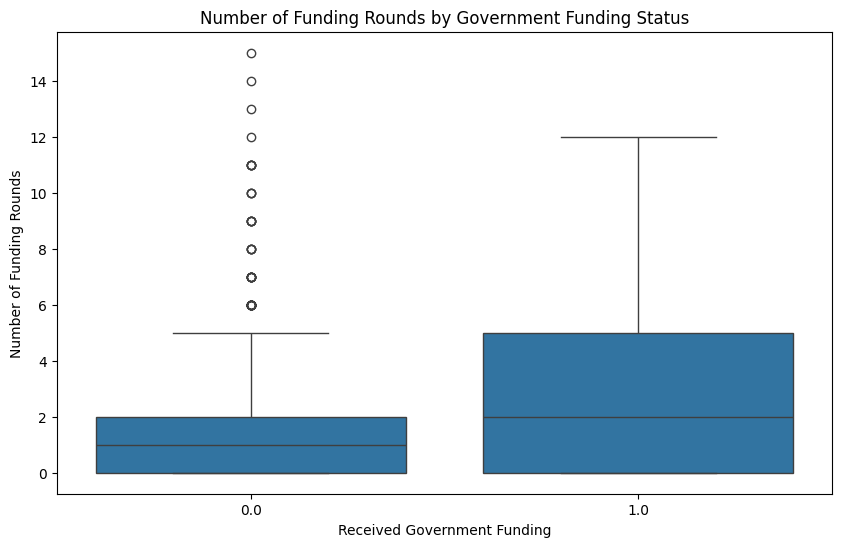

In [ ]:
# box plot showing number of funding rounds by government funding status
plt.figure(figsize=(10, 6))
sns.boxplot(x=y, y=X['num_funding_rounds'])
plt.title('Number of Funding Rounds by Government Funding Status')
plt.xlabel('Received Government Funding')
plt.ylabel('Number of Funding Rounds')
plt.show()